In [221]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from category_encoders import TargetEncoder, OneHotEncoder
import warnings
import pgeocode
import datetime
from math import radians
import joblib
import json
warnings.filterwarnings("ignore")
%matplotlib inline

# 1) Data Formatting

## Open Excel File in DataFrame

In [2]:
df = pd.read_excel('CarData.xlsx')

In [3]:
data = df.copy()

In [4]:
print(len(data.index))

62962


## Remove Incorrect Records

In [5]:
def find_incorrect_records(make, trim):
  if make in trim:
    return False
  return True

In [6]:
for i, row in data.iterrows():
  if find_incorrect_records(row['Make'], row['Trim']):
    data = data.drop(i)

## Remove Duplicates

In [7]:
data = data.drop_duplicates(subset=['VIN'])

In [8]:
data = data.drop('VIN', axis=1)

In [9]:
print(len(data.index))

61379


## Parse Column Information

In [10]:
def parse_year(car_string):
  match = re.search(r'\b(19|20)\d{2}\b', car_string)
  return int(match.group(0)) if match else None

def parse_trim(car_string, make, model):
  if make in car_string:
    trim = car_string.split(make, 1)[1]
    if model in trim:
      trim = trim.split(model, 1)[1]
      trim = trim.replace('for Sale', '')
      return str(trim.strip())
    else:
      return None
  else:
    return None

def parse_zip_code(location):
  if type(location) == str:
    zip = location.split(' ')[-1]
    return str(zip)
  return None

def parse_price(price):
  if type(price) == str:
    num = price.replace('$','')
    num = num.replace(',','')
    return int(num)
  return None

def parse_miles(miles):
  if type(miles) == str:
    mileage = miles.replace(' miles', '')
    mileage = mileage.replace(',','')
    return int(mileage.strip())
  return None

def parse_engine_size(engine):
  if type(engine) == str and '-cylinder' in engine:
    size = engine.replace('-cylinder','')
    return int(size.strip())
  return None

def parse_seats(seats):
  if type(seats) == str and 'seater' in seats:
    seats = seats.replace('seater','')
    return int(seats.strip())
  return None

In [11]:
data['Year'] = data['Year'].apply(parse_year)

data['Trim'] = data.apply(lambda row: parse_trim(row['Trim'], row['Make'], row['Model']), axis=1)

data['Location'] = data['Location'].apply(parse_zip_code)

data['Price'] = data['Price'].apply(parse_price)

data['Mileage'] = data['Mileage'].apply(parse_miles)

data['Engine_Size'] = data['Engine_Size'].apply(parse_engine_size)

data['Seats'] = data['Seats'].apply(parse_seats)

data.loc[data['Fuel_Type'] == 'Electric', 'Engine_Size'] = 0

data.loc[data['Fuel_Type'] == 'Natural Gas', 'Fuel_Type'] = 'Gas'

## Remove Some Null Values

In [12]:
len(data.index)

61379

In [13]:
data.sample(1)

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Seats,Drive_Type
26639,Hyundai,Genesis Coupe,2010,3.8L,33023,8895.0,120217.0,Automatic,[Nca] Silverstone,6.0,Gas,NaN,4.0,RWD


In [14]:
data = data.drop(data[data['Trim'].isna()].index)

In [15]:
data = data.drop(data[data['Trim']==''].index)

In [16]:
len(data.index)

59749

In [17]:
data.isna().sum().sum()

np.int64(28568)

## Replace Missing Engine Size

In [18]:
print("Engine Size: ", data['Engine_Size'].unique())

Engine Size:  [ 6.  4.  0. nan  8. 12.  5. 10.  3. 16.]


In [19]:
data['Engine_Size'].isna().sum()

np.int64(758)

In [20]:
def med_engine_size(model, year, trim, data, window=2):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  median_engine_size = relevant_data['Engine_Size'].median()
  return median_engine_size if not pd.isna(median_engine_size) else np.nan

In [21]:
def fill_nan_with_median(row):
  if pd.isna(row['Engine_Size']):
    return med_engine_size(row['Model'], row['Year'], row['Trim'], data)
  return row['Engine_Size']

In [22]:
data['Engine_Size'] = data.apply(fill_nan_with_median, axis=1)

In [23]:
data['Engine_Size'].isna().sum()

np.int64(624)

## Replace Missing Fuel Type

In [24]:
print("Fuel Type: ", data['Fuel_Type'].unique())

Fuel Type:  ['Gas' 'Hybrid' 'Electric' 'Plug-in Hybrid' 'Diesel' 'Flex fuel' nan]


In [25]:
data['Fuel_Type'].isna().sum()

np.int64(538)

In [26]:
def most_common_fuel_type(model, year, data, window=5):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1]))]
  common_fuel_type = relevant_data['Fuel_Type'].mode()
  return common_fuel_type[0] if not common_fuel_type.empty else np.nan

In [27]:
def fill_nan_with_fuel_type(row):
  if pd.isna(row['Fuel_Type']):
    return most_common_fuel_type(row['Model'], row['Year'], data)
  return row['Fuel_Type']

In [28]:
data['Fuel_Type'] = data.apply(fill_nan_with_fuel_type, axis=1)

In [29]:
data['Fuel_Type'].isna().sum()

np.int64(85)

## Replace Missing Transmission

In [30]:
print("Transmission: ", data['Transmission'].unique())

Transmission:  ['Automatic' 'Manual' 'CVT' 'Red' nan]


In [31]:
data = data[data['Transmission'] != 'Red']

In [32]:
data['Transmission'].isna().sum()

np.int64(1418)

In [33]:
def most_common_transmission(model, year, trim, data, window=5):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  common_transmission = relevant_data['Transmission'].mode()
  return common_transmission[0] if not common_transmission.empty else np.nan

In [34]:
def fill_nan_with_transmission(row):
  if pd.isna(row['Transmission']):
    return most_common_transmission(row['Model'], row['Year'], row['Trim'], data)
  return row['Transmission']

In [35]:
data['Transmission'] = data.apply(fill_nan_with_transmission, axis=1)

In [36]:
data['Transmission'].isna().sum()

np.int64(201)

## Replace Missing Gas Mileage

In [37]:
print("Gas Mileage: ", data['Gas_Mileage'].unique())

Gas Mileage:  [ 20.  21.  22.  28.  29.  25.  24.  32.  33.  30.  18.  19.  17.  nan
  23.  15.  27.  26.  87.  77.  13.  14.  16.  12.  34.  83.  31.  68.
  54.  78.  74.  79.  85.  82.  75.  95.  93. 100.  61.  50.  60.  81.
  73.  11.  47.  10.   9.  46.  67.  36.  71.  62.  65.  64. 124. 117.
 113. 111. 118.  96. 109. 120.  91. 105.  90.  76.  69.  86.  56.  89.
  88.  92. 115. 119.  35. 108.  98. 106.  94.  84.  44.  51. 112. 116.
  40.  41.  39. 102.  70.  66. 107.  97. 103.  42.  37.  99.  53.  48.
  43.  45. 110.  38.  52. 114. 121. 127.  55.  58.  59.  80.  49. 101.
 104. 123. 125. 122.  57.  63.]


In [38]:
data['Gas_Mileage'].isna().sum()

np.int64(12800)

In [39]:
def most_common_gas_mileage(model, year, trim, data, window=4):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  common_gas_mileage = relevant_data['Gas_Mileage'].mode()
  return common_gas_mileage[0] if not common_gas_mileage.empty else np.nan

In [40]:
def fill_nan_with_gas_mileage(row):
  if pd.isna(row['Gas_Mileage']):
    return most_common_gas_mileage(row['Model'], row['Year'], row['Trim'], data)
  return row['Gas_Mileage']

In [41]:
data['Gas_Mileage'] = data.apply(fill_nan_with_gas_mileage, axis=1)

In [42]:
data['Gas_Mileage'].isna().sum()

np.int64(8262)

## Replace Missing Drive Type

In [43]:
print("Drive Type: ", data['Drive_Type'].unique())

Drive Type:  ['FWD' 'AWD' 'RWD' 'FOUR_WD' nan '4 seater' 'FOUR_X_FOUR' '7 seater'
 'FOUR_X_TWO' 'JTJBC1BA4D2050855']


In [44]:
data = data.drop(data[data['Drive_Type'] == 'JTJBC1BA4D2050855'].index)
data = data.drop(data[data['Drive_Type'] == '4 seater'].index)
data = data.drop(data[data['Drive_Type'] == '7 seater'].index)
replacements = {
    'FOUR_WD': 'AWD',
    'FOUR_X_FOUR': 'AWD',
    'FOUR_X_TWO': 'RWD'
}

data['Drive_Type'] = data['Drive_Type'].replace(replacements)

In [45]:
data['Drive_Type'].isna().sum()

np.int64(704)

In [46]:
def most_common_drive_type(model, year, trim, data, window=4):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  common_drive_type = relevant_data['Drive_Type'].mode()
  return common_drive_type[0] if not common_drive_type.empty else np.nan

In [47]:
def fill_nan_with_drive_type(row):
  if pd.isna(row['Drive_Type']):
    return most_common_drive_type(row['Model'], row['Year'], row['Trim'], data)
  return row['Drive_Type']

In [48]:
data['Drive_Type'] = data.apply(fill_nan_with_drive_type, axis=1)

In [49]:
data['Drive_Type'].isna().sum()

np.int64(533)

## Replace Missing Mileage

In [50]:
data['Mileage'].isna().sum()

np.int64(2753)

In [51]:
def average_mileage(model, year, data, window=1):
    year_range = (year-window, year+window)
    relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1]))]
    avg_mlg = relevant_data['Mileage'].mean()
    if pd.isna(avg_mlg):
        return np.nan
    noise = avg_mlg*0.05
    return np.random.normal(avg_mlg, noise)

In [52]:
def fill_nan_with_miles(row):
  if pd.isna(row['Mileage']):
    return average_mileage(row['Model'], row['Year'], data)
  return row['Mileage']

In [53]:
data['Mileage'] = data.apply(fill_nan_with_miles, axis=1)

In [54]:
data['Mileage'].isna().sum()

np.int64(56)

## Removing Final Null Values

In [55]:
data.sample()

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Seats,Drive_Type
61478,Volvo,C40 Recharge,2024,Twin Plus,11232,60740.0,11.0,Automatic,Onyx Black Metallic,0.0,Electric,99.0,5.0,AWD


In [56]:
print("Price: ", data['Price'].isna().sum())
print("Mileage: ", data['Mileage'].isna().sum())
print("Transmission: ", data['Transmission'].isna().sum())
print("Color: ", data['Color'].isna().sum())
print("Engine_Size: ", data['Engine_Size'].isna().sum())
print("Fuel_Type: ", data['Fuel_Type'].isna().sum())
print("Gas Mileage: ", data['Gas_Mileage'].isna().sum())
print("Drive_Type: ", data['Drive_Type'].isna().sum())

Price:  6425
Mileage:  56
Transmission:  201
Color:  2832
Engine_Size:  624
Fuel_Type:  85
Gas Mileage:  8262
Drive_Type:  533


In [57]:
data.isna().sum().sum()

np.int64(19353)

In [58]:
data = data.dropna()

In [59]:
len(data.index)

44463

In [60]:
data.isna().sum().sum()

np.int64(0)

## Add Coordinates From Zip Code

In [61]:
nomi = pgeocode.Nominatim('us')


latitudes = []
longitudes = []

for zip_code in data['Location']:
    location = nomi.query_postal_code(zip_code)
    latitudes.append(location.latitude if location is not None else None)
    longitudes.append(location.longitude if location is not None else None)

data['Latitude'] = latitudes
data['Longitude'] = longitudes
data['Latitude'] = data['Latitude'].apply(radians)
data['Longitude'] = data['Longitude'].apply(radians)


In [62]:
data = data.drop(columns=['Location'])

## Replace Year Column

In [63]:
current_year = datetime.datetime.now().year
data['Age'] = current_year - data['Year'].astype(int)
data = data.drop(columns='Year')

In [64]:
data.sample(5)

,Make,Model,Trim,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Seats,Drive_Type,Latitude,Longitude,Age
54510,Subaru,Ascent,Touring,40995.0,4627.0,CVT,Gray,4.0,Gas,21.0,7.0,AWD,0.706871,-1.300293,1
31837,Jeep,Grand Cherokee L,Laredo,33499.0,26938.0,Automatic,Bright White Clearcoat,6.0,Gas,21.0,6.0,AWD,0.709417,-1.306012,2
9613,Cadillac,XTS,3.6L V6,12995.0,95652.0,Automatic,Black,6.0,Gas,21.0,5.0,FWD,0.692007,-1.317994,11
58797,Toyota,RAV4 Prime,SE,33995.0,43895.0,CVT,Midnight Black Metallic,4.0,Plug-in Hybrid,94.0,5.0,AWD,0.713459,-1.273261,3
53329,Rolls-Royce,Wraith,Base,204996.0,32960.0,Automatic,Black,12.0,Gas,14.0,4.0,RWD,0.615403,-1.410299,5


In [65]:
data = data.dropna()

In [66]:
len(data.index)

44415

## Remove Seats

Removing seats lowers mae of models

In [67]:
data = data.drop(columns=['Seats'])

## Format Dataframe

In [82]:
data = data[data['Color']!='--']

In [68]:
price = data.pop('Price')
data.insert(13, 'Price', price)

In [69]:
age = data.pop('Age')
data.insert(2, 'Age', age)

In [70]:
data.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Price
45831,Mercedes-Benz,SL-Class,0,AMG SL 55,20.0,Automatic,Obsidian Black Metallic,8.0,Gas,16.0,AWD,0.711485,-1.291296,172465.0


# 2) Exploratory Data Analysis

In [ ]:
# Find the total number of cars per manufacturer in the dataset
plt.figure(figsize=(20, 15))
sns.countplot(y=data['Make'])
plt.title("Manufacturer Distribution")
plt.show()

In [ ]:
# Find the number of cars made in each year in the dataset
plt.figure(figsize=(20, 15))
sns.countplot(y=data.Year, palette='viridis')
plt.title("Year Distribution")
plt.show()

In [ ]:
# Number of cars per transmission type
plt.figure(figsize=(20, 15))
sns.countplot(x=data.Transmission, palette='Paired')
plt.title("Transmission Distribution")
plt.show()

In [ ]:
# unique elements in data
data.nunique()

In [ ]:
# fuel type distribution
plt.figure(figsize=(20, 15))
sns.countplot(y=data.Fuel_Type.sort_values(ascending=False), palette='Dark2')


In [ ]:
# Group rows by make
data.groupby('Make')[['Engine_Size','Gas_Mileage', 'Price']].agg(['min','max','mean','median'])

In [ ]:
# average price by year
plt.figure(figsize=(20, 10))
data.groupby('Year')['Price'].mean().plot(kind='bar',color='g')
plt.title('Average Price by Year')
plt.show()

In [ ]:
plt.figure(figsize = (10, 10))
data.groupby('Transmission')['Price'].mean().plot(kind = 'bar', color = 'y')
plt.title("Average Price by Transmission", fontsize = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 15))
data.groupby(['Make'])['Price'].mean().sort_values(ascending = False).plot(kind = 'bar', fontsize = 15, color = 'black')
plt.title("Average Price per Manufacturer", fontsize = 20)
plt.show()

In [ ]:
# Group by Drive Type
plt.figure(figsize = (20, 15))
data.groupby(['Drive_Type'])['Price'].mean().sort_values(ascending = False).plot(kind = 'bar', fontsize = 15, color = 'orange')

In [ ]:
sns.scatterplot(x='Engine_Size',y='Gas_Mileage', data=data, color='r')
plt.show()

In [ ]:
# Boxplot of MPG
sns.boxplot(x='Gas_Mileage', data=data,color='r')

In [ ]:
sns.scatterplot(x='Fuel_Type',y='Gas_Mileage', data=data, color='r')
plt.show()

In [ ]:
plt.figure(figsize = (20, 15))
numeric_columns = ['Age', 'Mileage', 'Engine_Size', 'Seats', 'Price']
heatmap_data = data[numeric_columns].corr()
sns.heatmap(heatmap_data, annot=True, cmap='BuPu')

In [ ]:
# Gas Mileage by Year
plt.figure(figsize = (20, 15))
data.groupby('Year')['Gas_Mileage'].mean().plot(kind = 'bar', color = 'g')
plt.title("Gas Mileage by Year", fontsize = 20)
plt.show()

In [ ]:
# Mileage by Year
plt.figure(figsize = (20, 15))
data.groupby('Year')['Mileage'].mean().plot(kind = 'bar', color = 'g')
plt.title("Mileage by Year", fontsize = 20)
plt.show()

In [ ]:
data.info()

# 3) Data Manipulation

In [159]:
print(len(data.index))

44349


In [207]:
data[(data['Color']=='Vesuvius Gray Metallic') ]

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Price
1639,Audi,A6,3,quattro Sport Premium 45 TFSI,30205.0,Automatic,Vesuvius Gray Metallic,4.0,Gas,26.0,AWD,0.706052,-1.299961,27890.0
1718,Audi,A6 allroad,4,3.0T quattro Prestige,57200.0,Automatic,Vesuvius Gray Metallic,6.0,Gas,22.0,AWD,0.715564,-1.298980,44998.0
1742,Audi,A7,5,3.0T quattro Prestige,45792.0,Automatic,Vesuvius Gray Metallic,6.0,Gas,25.0,AWD,0.709222,-1.296005,39839.0
1814,Audi,A8,4,e quattro 55 TFSI,38266.0,Automatic,Vesuvius Gray Metallic,6.0,Plug-in Hybrid,54.0,AWD,0.698132,-1.313814,49585.0


In [161]:
frame = data.copy()

In [162]:
frame.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Price
50509,Oldsmobile,Bravada,22,Base,147408.0,Automatic,Red,6.0,Gas,16.0,AWD,0.740473,-1.452978,5500.0


## Split the Data

In [163]:
shuffled_data = shuffle(frame, random_state=1)
X = shuffled_data.drop('Price', axis=1)
y = shuffled_data['Price']

In [164]:
# Training and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [165]:
print("The size of the input train data is: {}".format(X_train.shape))
print("The size of the output train data is: {}".format(y_train.shape))
print("The size of the input test data is: {}".format(X_test.shape))
print("The size of the output test data is: {}".format(y_test.shape))

The size of the input train data is: (35479, 13)
The size of the output train data is: (35479,)
The size of the input test data is: (8870, 13)
The size of the output test data is: (8870,)


In [166]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
51257,Pontiac,Grand Prix,23,GT,145606.0,Automatic,Silver,6.0,Gas,21.0,FWD,0.634099,-1.612253


## Encode Make

In [167]:
make_encoder = TargetEncoder(cols='Make')

In [168]:
make_encoder.fit(X_train['Make'], y_train.to_frame()['Price'])

TargetEncoder(cols=['Make'])

In [169]:
X_train['Make'] = make_encoder.transform(X_train['Make'])

In [170]:
X_test['Make'] = make_encoder.transform(X_test['Make'])

In [171]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
14984,17727.60404,Town and Country,10,Touring,133160.0,Automatic,White,6.0,Flex fuel,14.0,FWD,0.713962,-1.294212


## Encode Model

In [172]:
model_encoder = TargetEncoder(cols='Model')
model_encoder.fit(X_train['Model'], y_train.to_frame()['Price'])
X_train['Model'] = model_encoder.transform(X_train['Model'])
X_test['Model'] = model_encoder.transform(X_test['Model'])

In [173]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
61256,21062.789889,26788.502901,6,2.0T 4Motion,62057.0,Automatic,Grey,4.0,Gas,22.0,AWD,0.717639,-1.29371


## Encode Trim

In [174]:
trim_encoder = TargetEncoder(cols='Trim')
trim_encoder.fit(X_train['Trim'], y_train.to_frame()['Price'])
X_train['Trim'] = trim_encoder.transform(X_train['Trim'])
X_test['Trim'] = trim_encoder.transform(X_test['Trim'])

In [175]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
59696,21062.789889,40351.939556,0,30144.911549,5.0,Automatic,Pure Gray,4.0,Gas,22.0,AWD,0.694468,-1.309637


## Encode Color

In [176]:
color_encoder = TargetEncoder(cols='Color')
color_encoder.fit(X_train['Color'], y_train.to_frame()['Price'])
X_train['Color'] = color_encoder.transform(X_train['Color'])
X_test['Color'] = color_encoder.transform(X_test['Color'])

In [177]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
35414,294330.878413,241813.249962,2,50187.492849,6000.0,Automatic,31046.905224,8.0,Gas,14.0,AWD,0.737869,-1.453172


## One Hot Encoding

In [178]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
44447,44674.9801,43046.529346,9,35968.743881,47800.0,Automatic,32367.198103,8.0,Gas,18.0,AWD,0.711644,-1.286638


In [179]:
encoder = OneHotEncoder()
encoder.fit(X_train[['Transmission', 'Fuel_Type', 'Drive_Type']])
one_hot_encoded_output_train = encoder.transform(X_train[['Transmission', 'Fuel_Type', 'Drive_Type']])
one_hot_encoded_output_test = encoder.transform(X_test[['Transmission', 'Fuel_Type', 'Drive_Type']])

In [180]:
X_train = pd.concat([X_train, one_hot_encoded_output_train], axis=1)
X_test = pd.concat([X_test, one_hot_encoded_output_test], axis=1)

In [181]:
X_train = X_train.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)
X_test = X_test.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)

In [182]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
45401,44674.9801,55445.950987,7,34378.864608,85214.0,32367.198103,8.0,16.0,0.709529,-1.296099,...,0,0,0,0,1,0,0,1,0,0


In [183]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35479 entries, 48062 to 57475
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Make            35479 non-null  float64
 1   Model           35479 non-null  float64
 2   Age             35479 non-null  int64  
 3   Trim            35479 non-null  float64
 4   Mileage         35479 non-null  float64
 5   Color           35479 non-null  float64
 6   Engine_Size     35479 non-null  float64
 7   Gas_Mileage     35479 non-null  float64
 8   Latitude        35479 non-null  float64
 9   Longitude       35479 non-null  float64
 10  Transmission_1  35479 non-null  int64  
 11  Transmission_2  35479 non-null  int64  
 12  Transmission_3  35479 non-null  int64  
 13  Fuel_Type_1     35479 non-null  int64  
 14  Fuel_Type_2     35479 non-null  int64  
 15  Fuel_Type_3     35479 non-null  int64  
 16  Fuel_Type_4     35479 non-null  int64  
 17  Fuel_Type_5     35479 non-null  

## Standardization/Normalization

In [184]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
21070,23553.878694,31116.412505,3,27639.516261,28447.0,39565.114227,4.0,22.0,0.714662,-1.295848,...,0,0,0,0,1,0,0,1,0,0


In [185]:
cols_to_scale = ['Age', 'Mileage', 'Engine_Size', 'Gas_Mileage', 'Latitude', 'Longitude']

In [186]:
# scaler = StandardScaler()
# X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
# X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale])

In [187]:
X_train.shape

(35479, 22)

# 4) Machine Learning Analysis

In [189]:
mse = []
mae = []

## K-Neighbors Regressor

In [190]:
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

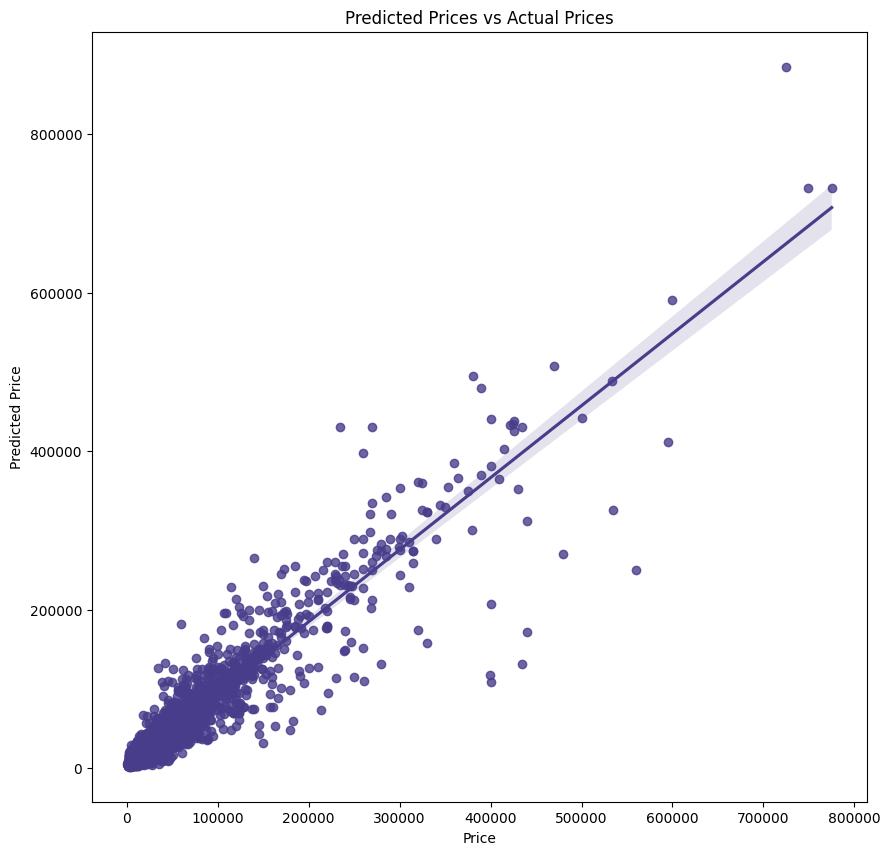

In [191]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='darkslateblue', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## PLS Regression

In [192]:
pls = PLSRegression(n_components=10)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

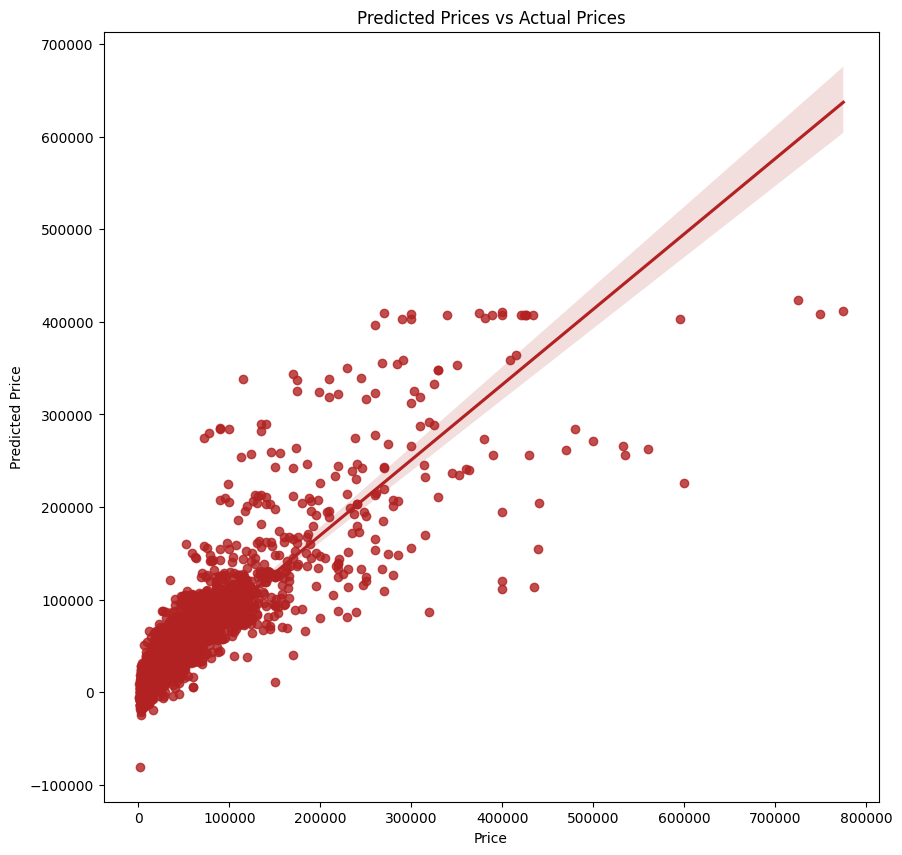

In [193]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='firebrick', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Decision Tree Regressor

In [194]:
dt = DecisionTreeRegressor(splitter='random')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

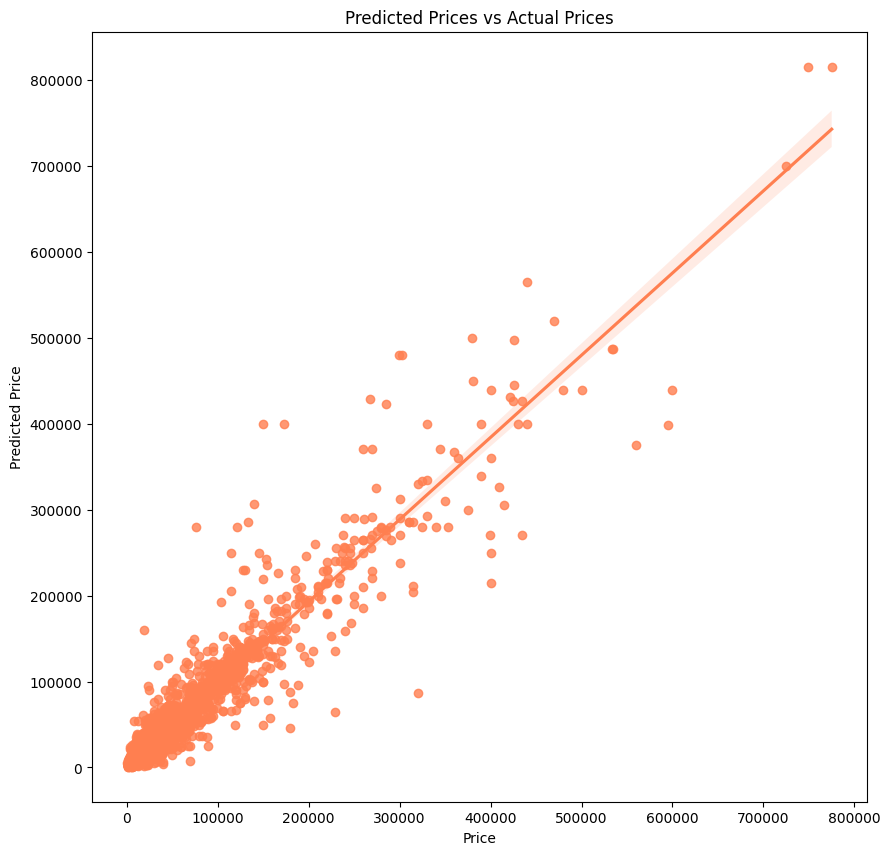

In [195]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='coral', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Random Forest Regressor

In [196]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

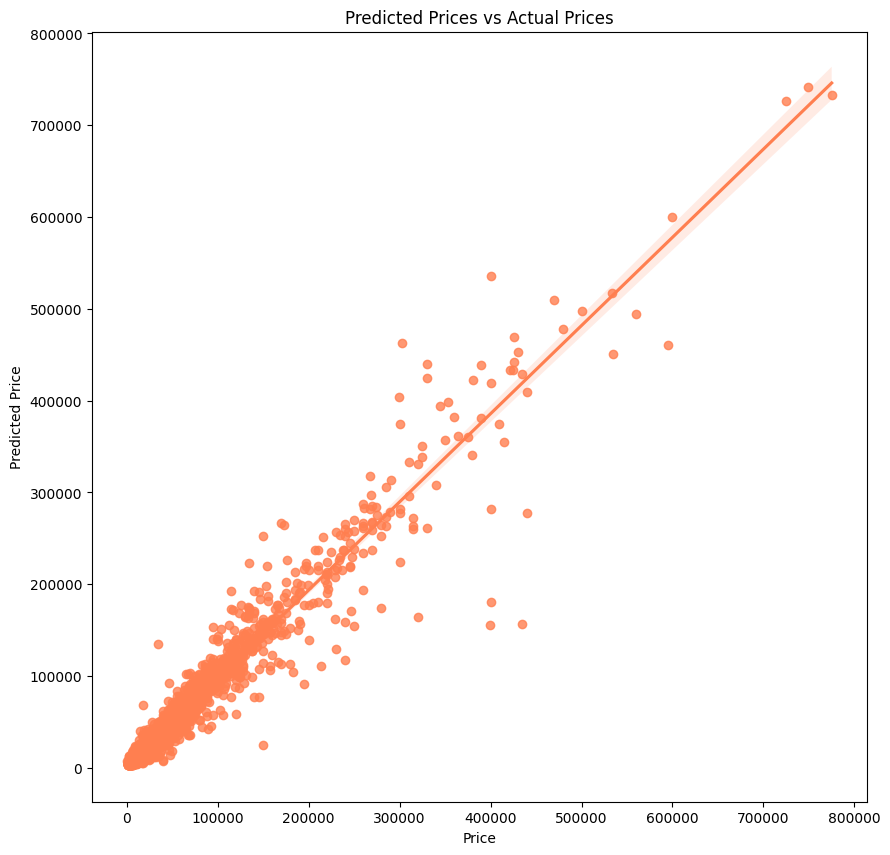

In [197]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='coral', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Gradient Boosting Regressor

In [198]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

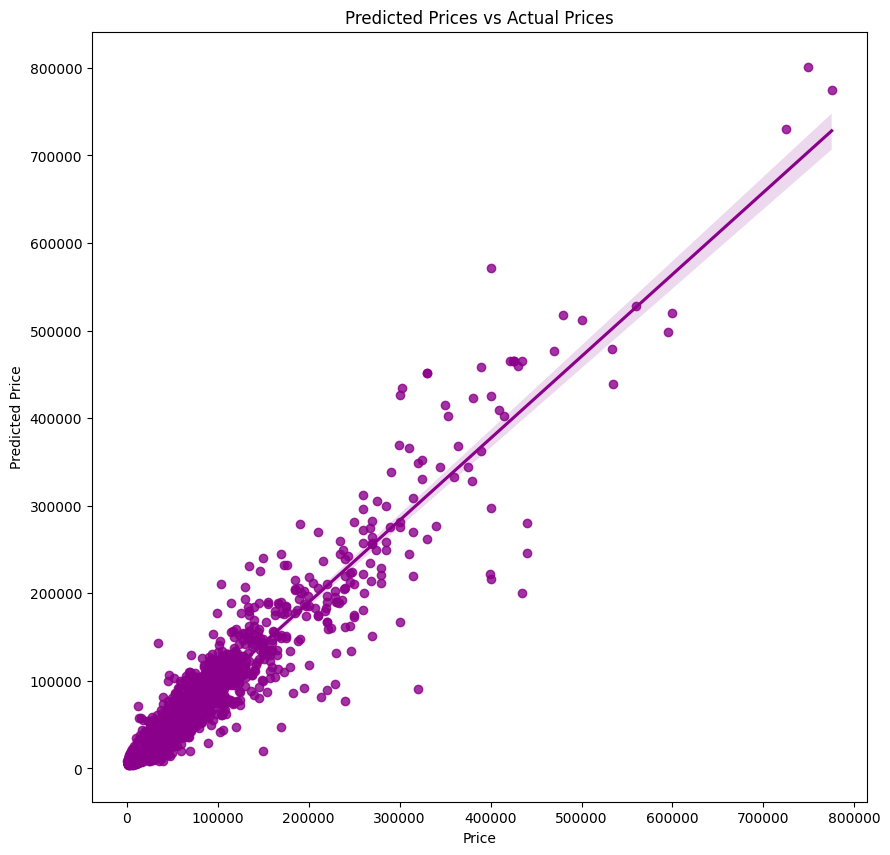

In [199]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='darkmagenta', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## MLP Regressor

In [200]:
gb = MLPRegressor(hidden_layer_sizes=50, alpha=0.001, solver='lbfgs', learning_rate='adaptive')
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

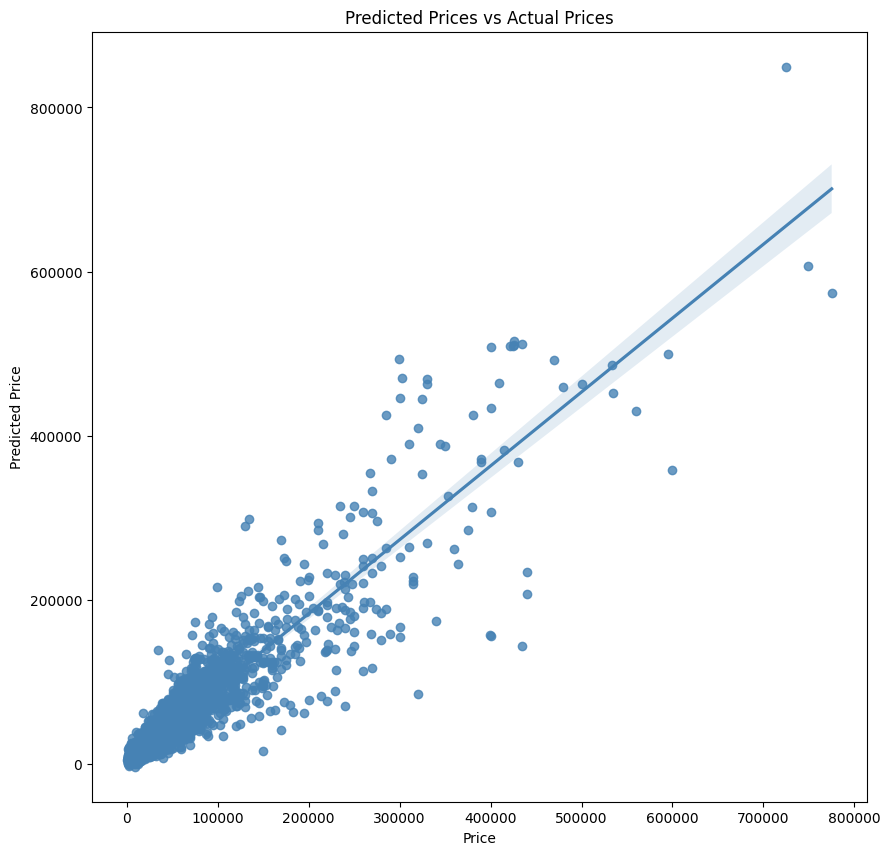

In [201]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='steelblue', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Dataframe of Machine Learning Models

In [202]:
models = {'Models': ['K Nearest Regressor', 'PLS Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'MLP Regressor'], 'Mean Absolute Error': mae, 'Mean Squared Error': mse}
model_dataframe = pd.DataFrame(models)

In [203]:
model_dataframe

,Models,Mean Absolute Error,Mean Squared Error
0,K Nearest Regressor,6049,219071474
1,PLS Regression,10729,482617968
2,Decision Tree Regressor,4934,174719262
3,Random Forest Regressor,3598,99988885
4,Gradient Boosting Regressor,5933,159989938
5,MLP Regressor,7954,284754016


## Barplot of Machine Learning Models

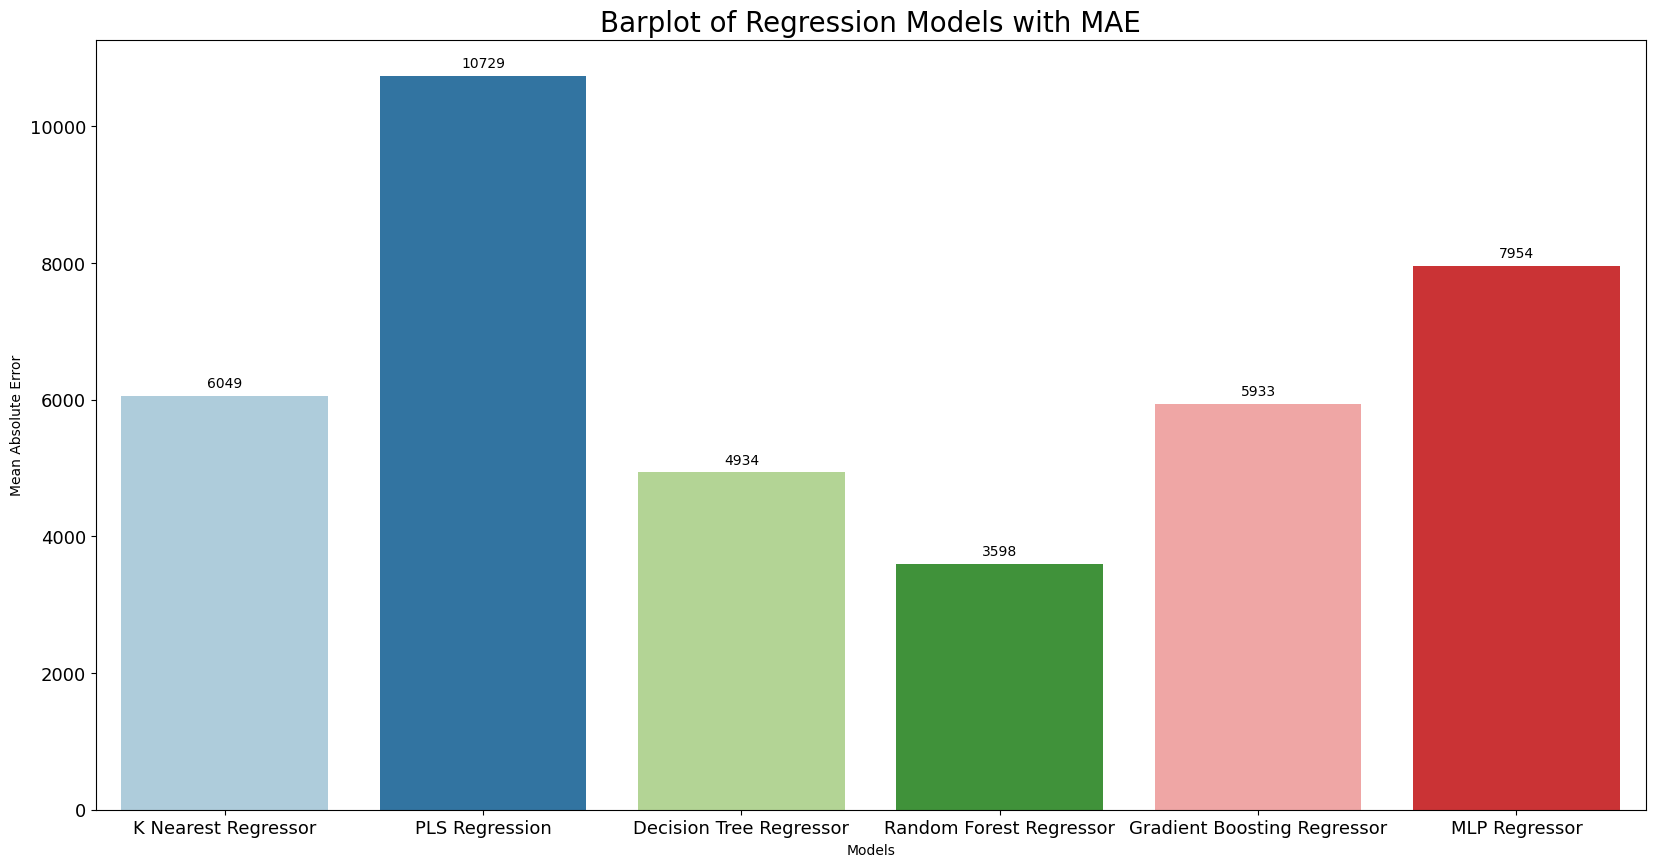

In [204]:
plt.figure(figsize=(20,10))
splot = sns.barplot(data=model_dataframe, x='Models', y='Mean Absolute Error', palette='Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Barplot of Regression Models with MAE", fontsize = 20)
plt.show()

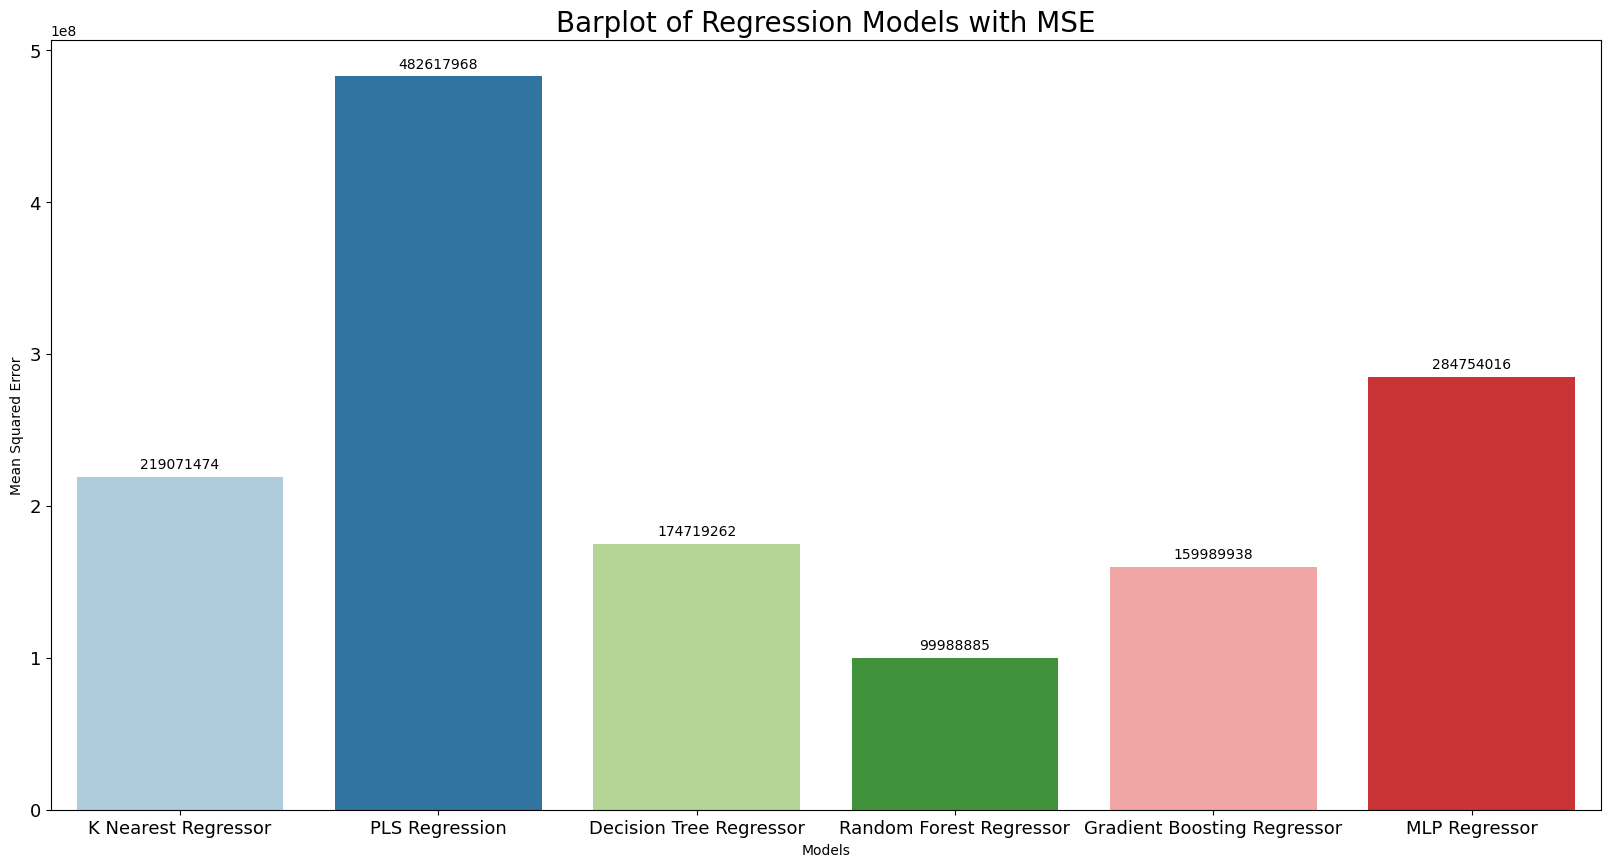

In [205]:
plt.figure(figsize=(20,10))
splot = sns.barplot(data=model_dataframe, x='Models', y='Mean Squared Error', palette='Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Barplot of Regression Models with MSE", fontsize = 20)
plt.show()

# 5) Predict 

Best Model: 
- Random Forest Regressor: 3598 MAE; 99988885 MSE
- target encoding on make model trim color
- onehot encoding on transmission fuel_type drive_type
- no scaling on Mileage, Engine_Size, Gas_Mileage, Latitude, Longitude
- coordinates in degrees

In [229]:
new_car = pd.DataFrame({
    'Make':['Audi'],
    'Model':['A8'],
    'Age':['2023'],
    'Trim':['quattro 55 TFSI'],
    'Mileage':7800,
    'Color':['Vesuvius Gray Metallic'],
    'Engine_Size':6,
    'Gas_Mileage':22,
    'Location':['08550'],
    'Transmission':['Automatic'],
    'Fuel_Type':['Gas'],
    'Drive_Type':['AWD'],
})

# replace year with age
current_year = datetime.datetime.now().year
new_car['Age'] = current_year - new_car['Age'].astype(int)

# get coordinates from zip code
nomi = pgeocode.Nominatim('us')
location = nomi.query_postal_code(new_car['Location'][0])
new_car['Latitude'] = location.latitude 
new_car['Longitude'] = location.longitude 
new_car = new_car.drop(columns=['Location'])

# target encoding
new_car['Make'] = make_encoder.transform(new_car['Make'])
new_car['Model'] = model_encoder.transform(new_car['Model'])
new_car['Trim'] = trim_encoder.transform(new_car['Trim'])
new_car['Color'] = color_encoder.transform(new_car['Color'])

# one hot encoding
categorical_features = new_car[['Transmission', 'Fuel_Type', 'Drive_Type']]
one_hot_encoded_new_car = encoder.transform(categorical_features)

one_hot_encoded_new_car_df = pd.DataFrame(one_hot_encoded_new_car, columns=encoder.get_feature_names_out())
new_car = pd.concat([new_car.drop(columns=['Transmission', 'Fuel_Type', 'Drive_Type']), one_hot_encoded_new_car_df], axis=1)



In [210]:
new_car

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
0,52250.027397,44612.462884,1,62292.896878,7800,36241.349172,6,22,40.2669,-74.6511,...,0,0,0,0,1,0,0,1,0,0


In [230]:
predicted_price = rf.predict(new_car)
print(predicted_price)

[74082.86]


# 6) Export Required Information

## Export Model

In [214]:
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

## Export Makes and Models

In [223]:
makes_to_models = data.groupby('Make')['Model'].apply(lambda x: sorted(set(x))).to_dict()

In [224]:
print(makes_to_models)

{'AMC': ['Eagle 30'], 'Acura': ['CL', 'ILX', 'Integra', 'Legend', 'MDX', 'NSX', 'RDX', 'RL', 'RLX', 'RSX', 'SLX', 'TL', 'TLX', 'TSX', 'TSX Sport Wagon', 'ZDX'], 'Alfa Romeo': ['4C', 'GTV6', 'Giulia', 'Spider', 'Stelvio', 'Tonale'], 'Aston Martin': ['DB11', 'DB12', 'DB9', 'DBS', 'DBX', 'Rapide AMR', 'Rapide S', 'V12 Vanquish', 'V12 Vantage', 'V8 Vantage', 'Vanquish', 'Vantage', 'Virage'], 'Audi': ['4000', 'A3', 'A3 Sportback e-tron', 'A4', 'A4 allroad', 'A5', 'A5 Sportback', 'A6', 'A6 allroad', 'A7', 'A8', 'Allroad', 'Cabriolet', 'Q3', 'Q4 e-tron', 'Q4 e-tron Sportback', 'Q5', 'Q5 Hybrid', 'Q5 Sportback', 'Q7', 'Q8', 'Q8 e-tron', 'Q8 e-tron Sportback', 'R8', 'RS 3', 'RS 4', 'RS 5', 'RS 5 Sportback', 'RS 6 Avant', 'RS 7', 'RS Q8', 'RS6', 'S3', 'S4', 'S5', 'S5 Sportback', 'S6', 'S7', 'S8', 'SQ5', 'SQ5 Sportback', 'SQ7', 'SQ8', 'SQ8 e-tron', 'SQ8 e-tron Sportback', 'TT', 'TT RS', 'TTS', 'e-tron', 'e-tron GT', 'e-tron Sportback'], 'BMW': ['1 Series', '2 Series', '3 Series', '4 Series', '5 S

In [225]:
with open('makes_models.json', 'w') as f:
    json.dump(makes_to_models, f, indent=4)

In [226]:
models_to_trims = data.groupby('Model')['Trim'].apply(lambda x: sorted(set(x))).to_dict()

In [227]:
print(models_to_trims)

{'1 Series': ['M'], '124 Spider': ['Prima Edizione Lusso'], '2': ['Launch Edition', 'Long Range Dual Motor'], '2 Series': ['228i xDrive', '228i xDrive Gran Coupe', '230i', '230i xDrive', 'M235i xDrive Gran Coupe', 'M240i xDrive'], '200': ['C', 'LX', 'Limited', 'S', 'Touring'], '240SX': ['SE'], '296 GTB': ['Base'], '3 Series': ['320i xDrive', '328d', '328i', '328i xDrive', '330e iPerformance', '330e xDrive', '330i', '330i xDrive', '330i xDrive Gran Turismo', 'M340i xDrive'], '300': ['Base', 'C', 'Limited', 'Motown', 'S', 'S V6', 'S V8', 'Touring', 'Touring L'], '300-Class': ['300 CD', '300 CE', '300 D', '300 E', '300 SD', '300 SDL', '300 SE', '300 SEL', '300 TD', '300 TE'], '3000GT': ['Spyder SL', 'VR-4 Turbo'], '300M': ['Base', 'Special'], '350-Class': ['350 SD'], '350Z': ['Base', 'COUPE', 'Coupe V6 3.5L Automatic Newer Tires 2 OWNERS', 'Enthusiast', 'Grand Touring', 'NISMO', 'Performance', 'ROADSTER', 'Touring', 'Touring Coupe 2D', 'Track'], '370Z': ['370Z', 'Auto', 'Base', 'Coupe', '

In [228]:
with open('models_to_trims', 'w') as f:
    json.dump(models_to_trims, f, indent=4)

In [231]:
makes_models_trims = data.groupby(['Make', 'Model'])['Trim'].apply(lambda x: sorted(set(x))).to_dict()

In [232]:
print(makes_models_trims)

{('AMC', 'Eagle 30'): ['Base'], ('Acura', 'CL'): ['2.3 Premium', '3.2', '3.2 Type-S'], ('Acura', 'ILX'): ['2.0L', '2.0L w/Tech', '8-Spd AT w/ Premium Package', 'Base', 'Premium & A-SPEC Packages', 'Premium Package', 'Premium Pkg Sedan 4D', 'Sedan 4D', 'Standard', 'Technology & A-SPEC Pkgs Sedan 4D', 'Technology Package', 'Technology Pkg Sedan 4D', 'Technology/A-Spec Package', 'w/Premium', 'w/Premium/A-SPEC Package', 'w/Premium/A-SPEC Pkg', 'w/Special Edition', 'w/Tech', 'w/Technology/A-SPEC Package', 'with Premium and A-Spec Package'], ('Acura', 'Integra'): ['Base', 'Type S', 'w/A-SPEC', 'w/Tech w/A-SPEC'], ('Acura', 'Legend'): ['Base', 'GS', 'L'], ('Acura', 'MDX'): ['Base', 'SH-AWD', 'SH-AWD Sport Utility 4D', 'SH-AWD w/A-SPEC', 'SH-AWD w/Advance', 'SH-AWD w/Advance w/RES', 'SH-AWD w/Power Tailgate w/Tech', 'SH-AWD w/Tech', 'SH-AWD w/Tech w/RES', 'Technology Package', 'Touring w/Navi w/RES', 'w/Tech'], ('Acura', 'NSX'): ['Base', 'NSX-T', 'SH-AWD Sport Hybrid', 'SH-AWD Type S'], ('Acur

In [235]:
json_compatible = {f"{make}_{model}": trims for (make, model), trims in makes_models_trims.items()}

In [236]:
with open('makes_models_to_trims', 'w') as f:
    json.dump(json_compatible, f, indent=4)

In [237]:
makes_models_colors = data.groupby(['Make', 'Model'])['Color'].apply(lambda x: sorted(set(x))).to_dict()

In [238]:
print(makes_models_colors)

{('AMC', 'Eagle 30'): ['Brown'], ('Acura', 'CL'): ['Black', 'Naples Gold Metallic', 'Red', 'San Marino Red', 'White'], ('Acura', 'ILX'): ['1', 'Apex Blue Pearl', 'Basque Red Pearl Ii', 'Bellanova White Pearl', 'Black', 'Blue', 'Burgundy', 'Crystal Black Pearl', 'Gray', 'Lunar Silver Metallic', 'Majestic Black Pearl', 'Modern Steel Metallic', 'Pearl White', 'Performance Red Pearl', 'Platinum White Pearl', 'Polished Metal Metallic', 'Silver', 'Slate Silver Metallic', 'Unknown', 'Whi', 'White'], ('Acura', 'Integra'): ['Apex Blue Pearl', 'Black', 'Gray', 'Green', 'Liquid Carbon Metallic', 'Lunar Silver Metallic', 'Majestic Black Pearl', 'Performance Red Pearl', 'Platinum White Pearl', 'Silver', 'Unknown'], ('Acura', 'Legend'): ['Charcoal', 'Gold', 'Green', 'White'], ('Acura', 'MDX'): ['Aspen White Pearl', 'Billet Silver Metallic', 'Black', 'Blue', 'Brown', 'Burgundy', 'Crystal Black Pearl', 'Fathom Blue Pearl', 'Graphite Luster Metallic', 'Gray', 'Grigio Metallic', 'Gunmetal Metallic', 'Li

In [239]:
json_compatible = {f"{make}_{model}": colors for (make, model), colors in makes_models_colors.items()}

In [240]:
with open('makes_models_to_colors', 'w') as f:
    json.dump(json_compatible, f, indent=4)

In [242]:
joblib.dump(make_encoder, 'encoders/make_encoder.pkl')
joblib.dump(model_encoder, 'encoders/model_encoder.pkl')
joblib.dump(trim_encoder, 'encoders/trim_encoder.pkl')
joblib.dump(color_encoder, 'encoders/color_encoder.pkl')
joblib.dump(encoder, 'encoders/onehotencoder.pkl')

['encoders/onehotencoder.pkl']